Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 11-March-2025

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from caveclient import CAVEclient
import seaborn as sns
from itertools import compress

In [2]:
def sort_partial_match(input_list, list_sorter):
    # Construct a dictionary mapping to be able to sort partial matches 
    sort_map = {name: next((idx for idx, val in enumerate(list_sorter) if name.startswith(val)),
                 len(input_list)) for name in input_list}

    sorted_list = sorted(input_list, key=sort_map.__getitem__)
    
    return sorted_list    

In [3]:
def hl_nt_dict():
    
    hl_nt_dict = {
        '0A': 'GABA',
        '0A/0B': 'GABA',
        '1A': 'ACH',
        '1B': 'GABA',
        '2A': 'GLUT',
        '3A': 'ACH',
        '3B': 'GABA',
        '4B': 'ACH',
        '5B': 'GABA',
        '6A': 'GABA',
        '6B': 'GABA',
        '7B': 'ACH',
        '8A': 'GLUT',
        '8B': 'ACH',
        '9A': 'GABA',
        '9B': 'GLUT',
        '10B': 'ACH',
        '11A': 'ACH',
        '11B': 'GABA',
        '12A': 'ACH',
        '12B': 'GABA',
        '13A': 'GABA',
        '13B': 'GABA',
        '14A': 'GLUT',
        '15B': 'GLUT',
        '16B': 'GLUT',
        '17A': 'ACH',
        '18B': 'ACH',
        '19A': 'GABA',
        '19B': 'ACH',
        '20A': 'ACH',
        '21A': 'GLUT', 
        '22A': 'ACH',
        '23B': 'ACH',
        '24B': 'GLUT'}
    
    return hl_nt_dict

In [4]:
# Select cell type
cell_type = ['claw_flx','claw_ext','hook_flx','hook_ext']

In [5]:
# Initialize CAVEclient
# This step requires an authentication token, see https://caveclient.readthedocs.io/en/latest/guide/authentication.html
client = CAVEclient()
datastack_name = 'fanc_production_mar2021'
client = CAVEclient(datastack_name)
client.materialize.version = 840

In [6]:
# Get IDs of FeCO neurons from annotation table  
df_feco = client.materialize.query_table('feco_axons_v0', filter_in_dict = {'cell_type': cell_type})

# Exclude partially reconstructed claw axons
pt_position_to_exclude = np.array([[9093, 101264, 3740], [9401, 100947, 3740]])
index_to_exclude = []
for index, _ in df_feco.iterrows():
    if (df_feco.pt_position[index] == pt_position_to_exclude).all(axis=1).any():
        index_to_exclude.append(index)
df_feco = df_feco.drop(index_to_exclude)

# Get IDs 
feco_ids = df_feco.pt_root_id.tolist()

In [7]:
# Query input synapses 
df_connectivity = client.materialize.synapse_query(post_ids = feco_ids)

In [8]:
# Remove connections less than syn_thresh  
syn_thresh = 3;
df_connectivity['syn_count'] = 1
df_connectivity = df_connectivity.groupby(['pre_pt_root_id','post_pt_root_id'])['syn_count'].sum().reset_index().sort_values('syn_count', ascending=False)
df_connectivity = df_connectivity[df_connectivity.syn_count >= syn_thresh]

In [9]:
# Compute connectivity matrix 
pre_ids = df_connectivity.pre_pt_root_id.unique().tolist()
post_ids = df_connectivity.post_pt_root_id.unique().tolist()

connectivity_matrix = np.zeros((len(pre_ids),len(post_ids)))
for pre_index, pre_id in enumerate(pre_ids):
    df = df_connectivity[df_connectivity.pre_pt_root_id == pre_id]
    for index, row in df.iterrows():
        post_index = post_ids.index(row.post_pt_root_id)
        syn_count = row.syn_count
        connectivity_matrix[pre_index, post_index] += syn_count

In [10]:
# Get FeCO IDs and partner IDs 
feco_ids = post_ids
partner_ids = pre_ids

In [11]:
# Get FeCO names     
feco_names = []
for feco_id in feco_ids:
    cell_type = df_feco.cell_type[df_feco.pt_root_id == feco_id].tolist()
    cell_id = df_feco.id[df_feco.pt_root_id == feco_id].tolist()
    name = ''.join(cell_type + ['_'] + [str(x) for x in cell_id])
    feco_names.append(name)

In [12]:
# Load annotation table with hemilineages of partner neurons 
df_annotation = client.materialize.query_table('upstream_feco_axons') 
annotation_ids = df_annotation.pt_root_id.tolist()

In [13]:
# Get partner names
partner_names = []
for partner_id in partner_ids:
    if partner_id in annotation_ids:
        name_type = str(df_annotation.cell_type[df_annotation.pt_root_id == partner_id].item())
        name = name_type + '_' + str(partner_id) 
    else:
        name = 'unknown_' + str(partner_id)
    partner_names.append(name)

In [25]:
# Sort columns of connectivity matrix based on FeCO subtype   
sort_list = ['claw_flx','claw_ext','hook_flx','hook_ext']
feco_names_sorted = sort_partial_match(feco_names, sort_list)
sort_index = [feco_names.index(i) for i in feco_names_sorted]

connectivity_matrix_sorted = connectivity_matrix[:,sort_index]
feco_names_sorted = [feco_names[i] for i in sort_index]
feco_ids_sorted = [feco_ids[i] for i in sort_index]

# Sort rows of connectiviity matrix based on FeCO subtype targeted, primary neurotransmitter, and hemilineage
nt_dict = hl_nt_dict()
nt_dict['hook'] = 'ACH'
nt_dict['club'] = 'ACH'
nt_dict['hair_plate'] = 'ACH'
nt_dict['unknown'] = 'Unknown'
hl_list = list(nt_dict.keys())

sort_index_list = []
for index, partner_id in enumerate(partner_ids):       
        # Get target index
        claw_index = [ix for ix, i in enumerate(feco_names_sorted) if "claw" in i]
        trans_index = claw_index[-1]
        neurons_targeted = list(np.where(connectivity_matrix_sorted[index,:]>0)[0])
        if max(neurons_targeted) <= trans_index:
            target_index = 0 # Claw
        elif min(neurons_targeted) > trans_index:
            target_index = 1 # Hook
        else:
            target_index = 2 # Claw and hook 

        # Get neurotransmitter index
        if partner_id in annotation_ids:
            cell_type = df_annotation.cell_type[df_annotation.pt_root_id == partner_id].item()
            # Look up primary neurotransmitter  
            nt = nt_dict[cell_type]
        else: 
            cell_type = 'unknown'
            nt = 'unknown'

        if nt == 'GABA':
            nt_index = 0
        elif nt == 'GLUT':
            nt_index = 1
        elif nt == 'ACH':
            nt_index = 2
        else:
            nt_index = 3

        # Get hemilineage index
        hl_index = hl_list.index(cell_type)
        
        sort_index_list.append([index, target_index, nt_index, hl_index])

# Sort idx_list based on attributes target_index, nt_index, and hl_index in descending order
sort_index_list = sorted(sort_index_list, key = lambda x: (x[1], x[2], x[3])) #, reverse = True)

# Get sort idx (first element of each list)
sort_index = [i[0] for i in sort_index_list]

# Sort columns of conn_mat and partner IDs
connectivity_matrix_sorted = connectivity_matrix_sorted[sort_index,:]
partner_names_sorted = [partner_names[i] for i in sort_index]
partner_ids_sorted = [partner_ids[i] for i in sort_index]

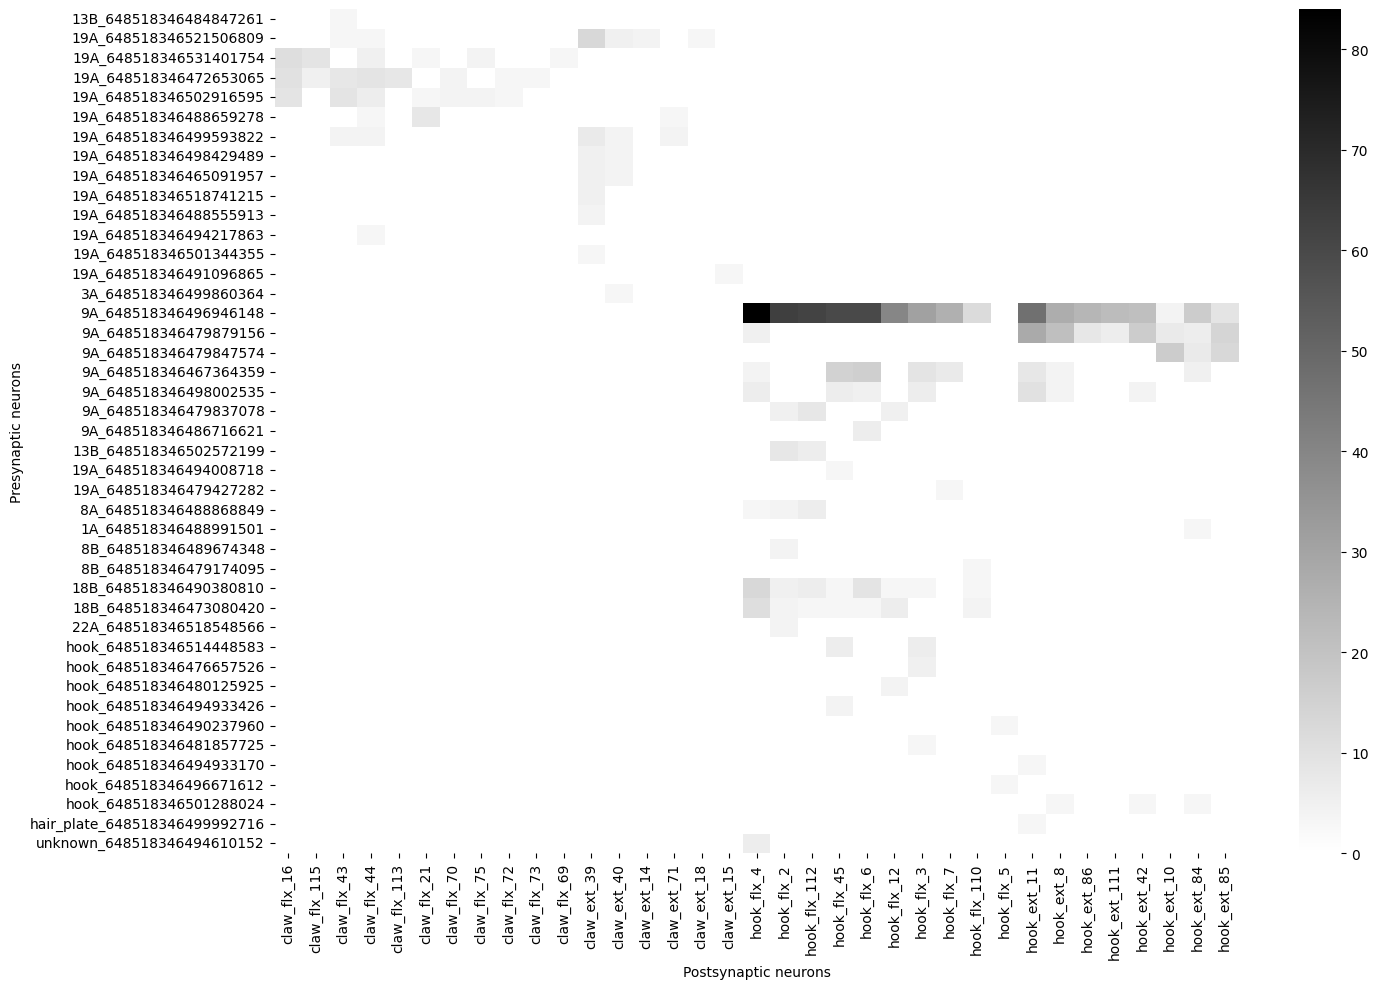

In [35]:
# Plot connectivity matrix
fig = plt.figure(figsize=(15,10))
cmap = sns.color_palette("gray_r", as_cmap=True)
xticklabels = feco_names_sorted
yticklabels = partner_names_sorted
sns.heatmap(connectivity_matrix_sorted, 
            cmap=cmap,
            xticklabels=xticklabels, 
            yticklabels=yticklabels)            
plt.xlabel('Postsynaptic neurons')
plt.ylabel('Presynaptic neurons')
plt.yticks(rotation=0)
plt.xticks(rotation=90)
fig.tight_layout()
plt.show()

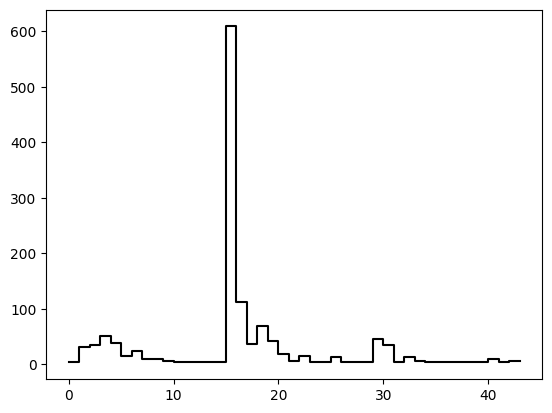

In [38]:
# Plot distribution of synapses
# For columns, set axis=0
# For rows, set axis=1
n_syn = np.sum(connectivity_matrix_sorted, axis=1)
plt.step(range(len(n_syn)+1), np.insert(n_syn, 0, n_syn[0]), color=[0,0,0]) # For step function, duplicate first value
plt.show()

## Calculate hook inputs from 9A  

In [ ]:
# Confirm row and column indices
# xticklabels[17:] # 17:
# yticklabels[15:22] # 15:22

In [18]:
n_syn_hook_all = int(np.sum(np.sum(connectivity_matrix_sorted[:,17:], axis=0)))

In [19]:
# Percent input synapses from all 9A neurons to all hook axons 
int(np.sum(np.sum(connectivity_matrix_sorted[15:22,17:], axis=1))) / n_syn_hook_all * 100

83.11567164179104

In [20]:
# Percent input synapses from chief 9A to all hook axons
int(np.sum(np.sum(connectivity_matrix_sorted[15,17:]))) / n_syn_hook_all * 100

56.809701492537314

In [21]:
# Percent input synapses from each 9A neuron to all hook axons  
np.sum(connectivity_matrix_sorted[15:22,17:], axis=1) / n_syn_hook_all * 100

array([56.80970149, 10.44776119,  3.45149254,  6.34328358,  3.82462687,
        1.67910448,  0.55970149])